# Exercise: Conversion Rate

From the project description: In brief, the goal of this exercise is to explore the available data, build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.

We'll start by importing pandas and the data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('conversion_data.csv')

df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


The conversion rate for the website is:

In [11]:
df.converted.mean()

0.03225806451612903

Let's group the data by conversion and look at the average of the numerical data.

In [4]:
df.groupby(by = 'converted').mean()

,age,new_user,total_pages_visited
converted,,,
0,30.703961,0.698382,4.550281
1,26.546765,0.297941,14.553529


Interestingly, the average age of a user that makes a purchase is much lower than the average age of a general user. We also see that: (1) users that made purchases spent more time on the page and (2) users that made purchases were much less likely to be new users (only $29\%$ were new users compared to the average $68\%$ new user rate).

Focusing on the new user labels, we look at the data grouped by whether or not a user is new.

In [5]:
df.groupby(by = 'new_user').mean()

,age,total_pages_visited,converted
new_user,,,
0,30.419140,5.280084,0.072002
1,30.639017,4.686155,0.014021


So returning users were around *five times* more likely to make a purchase! 

Pivoting to the amount of time spent on the page, we plot normalized histograms of the number of pages visited, segmented by whether the user made a purchase or not. The histograms below show that users who ultimately don't make purchases interact with the site very differently than folks who ultimately make a purchase.

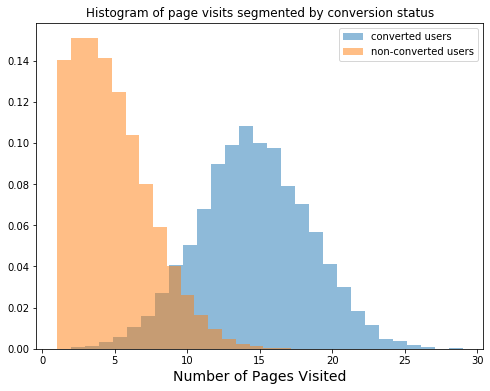

In [6]:
%matplotlib inline

converted_user_visits = df[df.converted==1].total_pages_visited.values
nonconverted_user_visits = df[df.converted==0].total_pages_visited.values
plt.figure(figsize=(8,6))
plt.hist(converted_user_visits,bins = 28, alpha=0.5, label="converted users", density = True)
plt.hist(nonconverted_user_visits,bins = 20, alpha=0.5, label="non-converted users", density = True)

plt.xlabel("Number of Pages Visited", size=14)
plt.title("Histogram of page visits segmented by conversion status")
plt.legend(loc='upper right')

plt.show()

Assessing the role age plays in whether a user makes a purchase, we plot the cumulative proportion of users who made purchases as a function of age (plotted in black). We plot this against the cumulative proportion of users of a given age (plotted in blue), for reference. The average age of a website user is around 30 and users under 30 make up roughly $50\%$ of all users. However, the plot shows that the proportion of users who make purchases and are under 30 is significantly higher than $50\%$, nearly $75\%$!

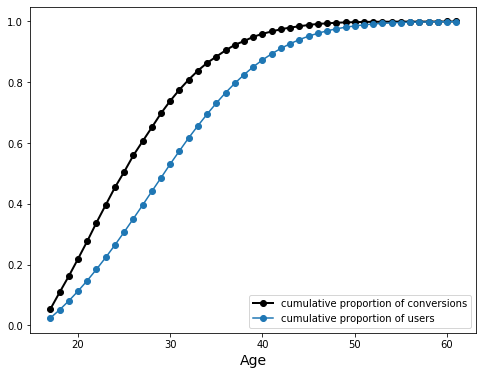

In [7]:
%matplotlib inline

#compute proportion of age
age_prop = df.age.value_counts().sort_index()/df.shape[0]
#compute proportion of conversion statistic
conversion_prop = df.groupby('age').converted.sum()/df.converted.sum()



plt.figure(figsize=(8,6))
plt.plot(conversion_prop.index.values[0:-15], np.cumsum(conversion_prop.values[0:-15]),'ko-',
         label = 'cumulative proportion of conversions', linewidth=2, markersize=6)
plt.plot(age_prop.index.values[0:-15], np.cumsum(age_prop.values[0:-15]), 'o-', 
         label = 'cumulative proportion of users' )

plt.xlabel("Age", size=14)
plt.legend(loc='lower right')

plt.show()

We pivot now to the categorical features. First, we group the data by the `source` feature. Most statistics look similar, aside from conversion rate for typing in the website directly, which is lower than the other methods for access. Roughly half the website users access the website through search. However, the conversion rate is slightly higher for users who access the site via ads compared to those who access via search. 

In [8]:
df.groupby(by = 'source').mean()

,age,new_user,total_pages_visited,converted
source,,,,
Ads,30.534742,0.685700,4.899538,0.034483
Direct,30.567978,0.686854,4.816901,0.028169
Seo,30.590835,0.684681,4.883946,0.032895


In [9]:
df.source.value_counts()

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

Grouping the data by the `country` and `source` features, we see that China's conversion rate is 30 times lower than average for the remaining countries. This is particularly unfortunate because nearly $25\%$ of users are from China.

In [10]:
df.groupby(['country','source']).mean()

age  new_user  total_pages_visited  converted
country source                                                     
China   Ads     30.650063  0.696628             4.563796   0.001484
        Direct  30.598694  0.698677             4.527286   0.001374
        Seo     30.720634  0.699532             4.559822   0.001224
Germany Ads     30.318351  0.674468             5.231649   0.066755
        Direct  30.443785  0.685056             5.113827   0.053422
        Seo     30.529695  0.675373             5.201026   0.064055
UK      Ads     30.432978  0.681832             5.127238   0.055630
        Direct  30.441380  0.685563             4.991016   0.046267
        Seo     30.466829  0.676022             5.099198   0.053905
US      Ads     30.528787  0.682872             4.957897   0.040580
        Direct  30.597969  0.682291             4.872296   0.032909
        Seo     30.573261  0.681333             4.941464   0.038508

In [11]:
df.country.value_counts()

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

Since the data is mixed (numerical and categorical) we'll use a gradient boosted decision tree ensemble to classify whether a user will make a purchase or not. We can use this classifier to obtain an estimate of conversion rate by averaging the classification across users. Unfortunately, the data is unbalanced. Therefore, accuracy is not a good metric for our classifier. Instead we'll use the area under the receiver operating characteristic as the metric to judge our classifier. 

In the following cell we do a grid search over our parameters and select the best scoring model. (This may take a minute to run)

In [14]:
#use one-hot encoding for categorical features
X = pd.get_dummies(df.drop(columns = ['converted']), columns = ['country', 'source'])
y = df.converted

from sklearn.model_selection import train_test_split

#split test data at 20% of training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


grid_values = {'n_estimators': [3,5,10], 'learning_rate': [0.1,0.05,0.01], 'max_depth':[5,4,3,2]}

gbc = GradientBoostingClassifier()

#do grid search with 4-fold cross validation
roc_grid = GridSearchCV(gbc, param_grid = grid_values, scoring = 'roc_auc', cv = 4)

roc_grid.fit(X_train,y_train)

#take the best model from our parameter search
gbc = roc_grid.best_estimator_

The AUC score for the test data is $0.982$. 

In [15]:
from sklearn.metrics import roc_auc_score

y_test_score = gbc.predict_proba(X_test)
roc_auc_score(y_test, y_test_score[:,1])

0.9825709483241323

We select the features that the model found to be most important. The features (ranked in order of importance) are: (1) The total pages visited, (2) Whether or not the user came from China, (3) Whether or not the user was returning, (4) The user's age

In [16]:
importance_ = gbc.feature_importances_

feature_importance = zip(X.columns.values, importance_)
feature_importance = pd.DataFrame(list(feature_importance), columns = ['feature', 'importance']).set_index('feature')

sorted_features = feature_importance.sort_values(by = 'importance',ascending = False)
sorted_features.index.values[0:4]

array(['total_pages_visited', 'country_China', 'new_user', 'age'],
      dtype=object)

# Recommendations:
The following recommendations are from the previous observations and our model.

* For the product team:
    
    1. The model and the analysis show that the amount of time users spend on the app is the most important feature for predicting conversion. We need to understand what is keeping users engaged when they do make a purchase. To do this, one would need to analyze the browsing pattern of users that convert. One could add site features that track which pages a returning user spends time on. For instance, are people who make purchases spending more time on the site because of the checkout process or can we distill site features that are keeping people engaged?
    2. Similarly, it would be useful to know how the browsing behavior of new users differs from returning users. Is there something on the site that returning users spend time on that new users miss? Evidence that something like this is going on is the fact that conversion rate differs among how people access the site. An advertisement is likely to take a user to a product, whereas directly typing in the url will not. 
    
* For the advertising team:

    1. The model and the analysis show that we need to increase the conversion rate among Chinese users and users under 30. Concentrate more advertisements among these two demographics. 